## Saving and Loading Models

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as tf_hub

TensorFlow 2.x selected.


In [0]:
from matplotlib import style

import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

In [0]:
style.use('ggplot')

tfds.disable_progress_bar()

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Transfer Learning Using TensorFlow Hub on Cats and Dogs With MobileNet V2

#### Load the Dataset Using TensorFlow Datasets

In [5]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))
splits

(NamedSplitAll()(tfds.percent[0:80]), NamedSplitAll()(tfds.percent[80:100]))

In [6]:
dataset_splits, dataset_info = tfds.load(name='cats_vs_dogs', 
                                         split=splits, 
                                         as_supervised=True, 
                                         with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [0]:
training_set, validation_set = dataset_splits

In [8]:
print(training_set)
print(validation_set)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [9]:
dataset_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=2.0.1,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    urls=['https://www.microsoft.com/en-us/download/details.aspx?id=54765'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    year

In [10]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
for example_tr in training_set:
  num_training_examples += 1

num_validation_examples = 0
for example_val in validation_set:
  num_validation_examples += 1

print("Number of Cats & Dogs Classes : {}".format(num_classes))
print("Number of Training Examples   : {}".format(num_training_examples))
print("Number of Validation Examples : {}".format(num_validation_examples))

Number of Cats & Dogs Classes : 2
Number of Training Examples   : 18622
Number of Validation Examples : 4640


#### Reformat Images

In [0]:
BATCH_SIZE = 32
IMG_RES = 224

def format_images(image, label):
  image = tf.image.resize(images=image, size=(IMG_RES, IMG_RES))/255.0
  return image, label

#### Batching

In [0]:
training_batches = training_set.shuffle(num_training_examples//4).map(format_images).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_images).batch(BATCH_SIZE).prefetch(1)

In [13]:
print(training_batches)
print(validation_batches)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [0]:
image_batch, label_batch = next(iter(training_batches.take(1)))

In [15]:
print(image_batch)
print(label_batch)

tf.Tensor(
[[[[0.5528804  0.529351   0.46660584]
   [0.57781726 0.55428785 0.4915427 ]
   [0.6594899  0.6359605  0.5732154 ]
   ...
   [0.53352356 0.502151   0.4276412 ]
   [0.50838804 0.48093703 0.41819194]
   [0.52020305 0.4927521  0.430007  ]]

  [[0.5705525  0.5470231  0.484278  ]
   [0.58103776 0.55750835 0.4947633 ]
   [0.5997882  0.5762588  0.5135137 ]
   ...
   [0.5397812  0.50840867 0.43389887]
   [0.5273171  0.49986613 0.43712103]
   [0.5004989  0.4730479  0.41030282]]

  [[0.5862033  0.56267387 0.49992883]
   [0.59315825 0.56962883 0.50688374]
   [0.5814543  0.55792487 0.49517977]
   ...
   [0.54148877 0.5101162  0.43560642]
   [0.5607578  0.53330684 0.4705617 ]
   [0.5097513  0.48230037 0.41955528]]

  ...

  [[0.9119486  0.9119486  0.9119486 ]
   [0.914916   0.914916   0.914916  ]
   [0.8957663  0.8957663  0.8957663 ]
   ...
   [0.6054888  0.58619606 0.57506156]
   [0.6244536  0.5891595  0.56051797]
   [0.65052813 0.615234   0.5799399 ]]

  [[0.9161247  0.9161247  0.916124

#### MobileNet Transfer Learning

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = tf_hub.KerasLayer(handle=URL, 
                                      input_shape=(IMG_RES, IMG_RES, 3))

#### Freezing the Variables of MobileNet

In [0]:
feature_extractor.trainable = False

#### Attach Classification Head

In [0]:
model_1 = tf.keras.Sequential([
  feature_extractor, 
  tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
])

#### Compile the Model

In [0]:
model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [20]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


#### Fit the Model

In [21]:
EPOCHS = 2

history = model_1.fit(training_batches, 
                      epochs=EPOCHS, 
                      validation_data=validation_batches)

Epoch 1/2
582/582 [==============================] - 64s 110ms/step - loss: 0.0526 - accuracy: 0.9828 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/2
582/582 [==============================] - 54s 93ms/step - loss: 0.0299 - accuracy: 0.9899 - val_loss: 0.0290 - val_accuracy: 0.9892


#### Plot the Training and Validation Graphs

In [22]:
data = {
    'train_acc' : history.history['accuracy'], 
    'train_loss' : history.history['loss'], 
    'val_acc' : history.history['val_accuracy'], 
    'val_loss' : history.history['val_loss']
}

history_df = pd.DataFrame(data=data, index=history.epoch)
display(history_df)

,train_acc,train_loss,val_acc,val_loss
0,0.982762,0.052579,0.988793,0.030750
1,0.989851,0.030822,0.989224,0.028982


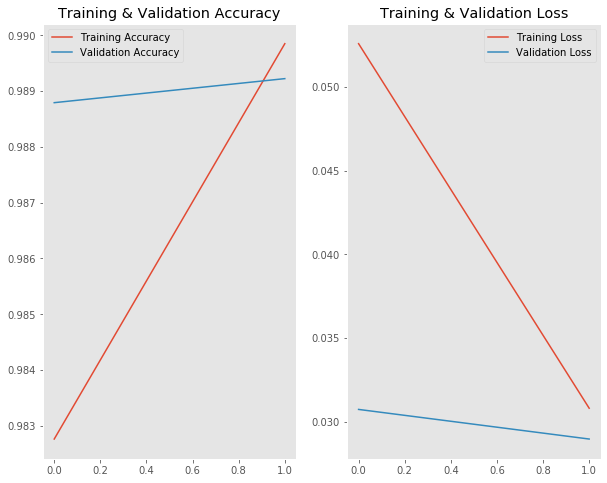

In [23]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Training & Validation Accuracy")
plt.plot(history_df.index, history_df['train_acc'], label='Training Accuracy')
plt.plot(history_df.index, history_df['val_acc'], label='Validation Accuracy')
plt.grid(False)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Training & Validation Loss")
plt.plot(history_df.index, history_df['train_loss'], label='Training Loss')
plt.plot(history_df.index, history_df['val_loss'], label='Validation Loss')
plt.grid(False)
plt.legend()

plt.savefig('./foo.png')
plt.show()

#### Check Predictions

In [24]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [0]:
predicted_batches = model_1.predict(image_batch)

In [26]:
print(predicted_batches)
print(predicted_batches.shape)

[[8.0237933e-06 9.9999201e-01]
 [9.9999738e-01 2.6600828e-06]
 [7.9100259e-04 9.9920899e-01]
 [9.9993670e-01 6.3295251e-05]
 [2.8962824e-03 9.9710375e-01]
 [5.8715278e-04 9.9941289e-01]
 [9.9979514e-01 2.0492813e-04]
 [3.2433780e-04 9.9967563e-01]
 [5.0519076e-03 9.9494803e-01]
 [1.9039524e-03 9.9809605e-01]
 [1.8324729e-03 9.9816751e-01]
 [9.9564350e-01 4.3565147e-03]
 [9.9961191e-01 3.8809868e-04]
 [8.1965339e-01 1.8034664e-01]
 [9.9995434e-01 4.5688339e-05]
 [9.9928880e-01 7.1113132e-04]
 [7.2139263e-02 9.2786074e-01]
 [9.2897451e-01 7.1025535e-02]
 [9.9999344e-01 6.6076836e-06]
 [9.9999797e-01 2.0043517e-06]
 [7.7152581e-05 9.9992287e-01]
 [9.9817228e-01 1.8277639e-03]
 [4.7555384e-03 9.9524444e-01]
 [1.3350014e-03 9.9866498e-01]
 [6.1790663e-04 9.9938202e-01]
 [9.9817681e-01 1.8231604e-03]
 [3.0584170e-03 9.9694151e-01]
 [9.9999547e-01 4.5303859e-06]
 [5.3329417e-04 9.9946672e-01]
 [4.7819347e-05 9.9995220e-01]
 [6.6122343e-03 9.9338770e-01]
 [9.9995995e-01 4.0022522e-05]]
(32, 2)

In [0]:
predicted_ids = np.argmax(predicted_batches, axis=-1)

In [28]:
print(predicted_ids)
print(predicted_ids.shape)

[1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0]
(32,)


In [29]:
print("True Labels      : {}".format(label_batch))
print("Predicted Labels : {}".format(predicted_ids))

True Labels      : [1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0]
Predicted Labels : [1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0]


In [30]:
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog',
       'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat',
       'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog',
       'cat', 'dog', 'dog', 'dog', 'cat'], dtype='<U3')

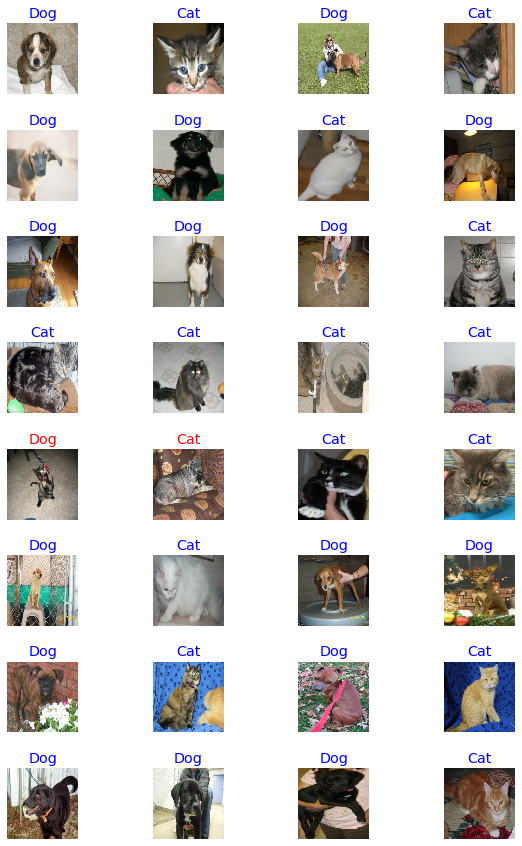

In [31]:
plt.figure(figsize=(10, 15))

for n in range(BATCH_SIZE):
  plt.subplot(8, 4, n+1)
  plt.subplots_adjust(hspace=0.5)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color=color)
  plt.grid(False)
  plt.axis('off')

plt.show()

In [32]:
int(time.time())

1573785446

### Save as Keras `.h5` Model

In [33]:
time_save = time.time()

export_path_keras = "./{}.h5".format(int(time_save))
print(export_path_keras)

model_1.save(filepath=export_path_keras)

./1573785446.h5


In [34]:
!ls

1573785446.h5  foo.png	sample_data


### Load the Keras `.h5` Model

In [0]:
reloaded_keras = tf.keras.models.load_model(filepath=export_path_keras, 
                                            custom_objects={'KerasLayer' : tf_hub.KerasLayer})

In [36]:
reloaded_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
result_batch = model_1.predict(image_batch)
reloaded_result_batch = reloaded_keras.predict(image_batch)

In [38]:
print(result_batch == reloaded_result_batch)

[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


### Export as SavedModel

In [39]:
time_save = time.time()

export_path_sm = "./{}".format(int(time_save))
print(export_path_sm)

tf.saved_model.save(obj=model_1, export_dir=export_path_sm)

./1573785455


In [40]:
!ls $export_path_sm

assets	saved_model.pb	variables


### Load the SavedModel

In [0]:
reloaded_sm = tf.saved_model.load(export_dir=export_path_sm)

In [42]:
print(reloaded_sm)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f887dc166a0>


In [0]:
result_batch = model_1.predict(image_batch)
reloaded_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

In [44]:
print(reloaded_sm_result_batch == result_batch)

[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


### Loading the SavedModel as Keras Model

In [45]:
time_save = time.time()

export_path_sm_keras = "./{}".format(int(time_save))
print(export_path_sm_keras)

tf.saved_model.save(obj=model_1, export_dir=export_path_sm_keras)

./1573785470


In [0]:
reloaded_sm_keras = tf.keras.models.load_model(filepath=export_path_sm_keras, 
                                               custom_objects={'KerasLayer' : tf_hub.KerasLayer})

In [47]:
reloaded_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
result_batch = model_1.predict(image_batch)
reloaded_sm_keras_batch = reloaded_sm_keras.predict(image_batch)

In [49]:
print(result_batch == reloaded_sm_keras_batch)

[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


### Download Model

In [50]:
!zip -r Lesson_8_sm.zip {export_path_sm}

  adding: 1573785455/ (stored 0%)
  adding: 1573785455/variables/ (stored 0%)
  adding: 1573785455/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: 1573785455/variables/variables.index (deflated 79%)
  adding: 1573785455/variables/variables.data-00000-of-00002 (deflated 88%)
  adding: 1573785455/saved_model.pb (deflated 92%)
  adding: 1573785455/assets/ (stored 0%)


In [51]:
!ls

1573785446.h5  1573785455  1573785470  foo.png	Lesson_8_sm.zip  sample_data


In [0]:
try:
  from google.colab import files
  files.download('./Lesson_8_sm.zip')
except Exception:
  pass